<a href="https://colab.research.google.com/github/SDS-AAU/SDS-master/blob/master/M3/notebooks/RNN_simple_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time series prediction with LSTMs
This notebook is adopted from [Machine Learning Mastery](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
Please visit the tutorial there for more details and to see variations of that using sliding windows and timesteps.




In [186]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [187]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')

In [188]:
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [189]:
data.set_index(pd.to_datetime(data.Month))

,Month,Passengers
Month,,
1949-01-01,1949-01,112
1949-02-01,1949-02,118
1949-03-01,1949-03,132
1949-04-01,1949-04,129
1949-05-01,1949-05,121
...,...,...
1960-08-01,1960-08,606
1960-09-01,1960-09,508
1960-10-01,1960-10,461


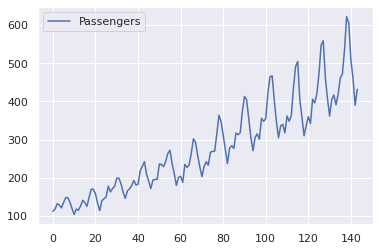

In [190]:
data.plot()

In [191]:
import numpy
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [192]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [193]:
# normalizing
scaler = MinMaxScaler(feature_range=(0, 1))
data['Passengers_scaled'] = scaler.fit_transform(data['Passengers'].values.reshape(-1, 1))

In [194]:
# create targets by shifting
data['Passengers+1'] = data.Passengers_scaled.shift(-1, fill_value=data.Passengers_scaled.iloc[-1])

In [195]:
data

,Month,Passengers,Passengers_scaled,Passengers+1
0,1949-01,112,0.015444,0.027027
1,1949-02,118,0.027027,0.054054
2,1949-03,132,0.054054,0.048263
3,1949-04,129,0.048263,0.032819
4,1949-05,121,0.032819,0.059846
...,...,...,...,...
139,1960-08,606,0.969112,0.779923
140,1960-09,508,0.779923,0.689189
141,1960-10,461,0.689189,0.552124
142,1960-11,390,0.552124,0.633205


In [196]:
# get the data as matrix
data_p = data.iloc[:,2:].values.astype('float32')

In [197]:
# split into train and test sets
train_size = int(len(data_p) * 0.67)
test_size = len(data_p) - train_size
train, test = data_p[0:train_size,:], data_p[train_size:len(data_p),:]
print(len(train), len(test))

96 48


In [200]:
X_train = train[:,0]
y_train = train[:,1]

X_test = test[:,0]
y_test = test[:,1]

In [203]:
# reshape input to be [samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], 1, 1))

In [204]:
# build the network

model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [205]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

In [207]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [209]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [210]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.91 RMSE
Test Score: 51.43 RMSE


In [211]:
data['Passengers_pred'] = data['Passengers']

In [212]:
testPredict.shape

(48, 1)

In [213]:
data['Passengers_pred'].iloc[-48:] = testPredict.flatten()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [214]:
data['Passengers_pred']

0      112.000000
1      118.000000
2      132.000000
3      129.000000
4      121.000000
          ...    
139    543.765808
140    472.821198
141    434.984528
142    373.482056
143    410.457367
Name: Passengers_pred, Length: 144, dtype: float64

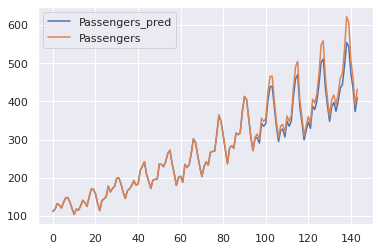

In [215]:
data.loc[:,['Passengers_pred','Passengers']].plot()